In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/10/08 13:58
# @Author  : Wang Yujia
# @File    : PT_demo.ipynb

# @Description : 1. 用SA试做一下inference of PT model's 3 params 2. 复现table 1的code见PT_demo_table1.ipynb

# 1. Preparations
## 1.1 Import

In [14]:
import numpy as np
import pandas as pd
import sympy
import time
import datetime
from sko.SA import SA
from sko.tools import set_run_mode
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2 Global Settings

In [7]:
# auction settings from Swoopo
#b = 0.75
#v = 169.99
#d = 0.15

# auction settings from paper's Fig.1 left
b= 0.75
v = 27.99
d = 0.01

# cnt_row = data_i.shape[0]
cnt_row = 5
# cnt_n_2 = data_i['cnt_n_2']
cnt_n_2 = [1,1,2,3,1]
#N_i = data_i['N']
N_i = [500,50,100,200,300]
# max duration from Swoopo
max_T = 831

# from paper's Table 5 'All auction'
# alpha = 0.025
# delta = 0.85
# labda = 3.72

# initial params
table_5_M = [0.025,0.85,3.72]
# lower/ upper bound
lb = [-0.3,0.01,0.01]
ub = [0.3, 2, 16]

# paper setting
#T = int((v-b)/d)

# 2. Infer with SA
1. 用SA 求解参数。
2. 定义函数之后，求一个uniq auction下的u和p
3. 然后用p求NLL作为最终的loss

## 2.1 function definition
1. 根据Eq(7)-(9)

In [8]:
def C(t,b):
    return 0.2*t*b

def OMEGA(p,delta):
    return p**delta * ((p**delta + (1-p)**delta)**(-1/delta))

# valuation function
def f(x, alpha):
    return (1-sympy.E**(-alpha*x))/alpha
    # when x < 0, in fact, it shoule be : (-labda)*(1-sympy.E**(alpha*x))/alpha

def f_Equi(t,v,d,b,alpha,labda,delta):
    u = sympy.Symbol('u')

    tmp = v-d*t-C(t-1,b) - b

    func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
    func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

    if(tmp >= 0):
        return sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
    else:
        return sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)

## 2.2 Loss func
1. 这个函数比较长 没办法，求u需要用SA给的params的值。`loss_func`的返回值是NLL
2. 求解`U_i[t]` which is a array with shape of (max(N)),`U_i[t]`就是paper里的`p_t`
3. for different auction, the duration is N_i[idx] and the value of duration it is various
4. nll计算时乘的`cnt_n_2[idx]`是为了减少计算次数，表示duration相同的auction的数量。

In [9]:
def loss_func(params):

    start_time = datetime.datetime.now()

    alpha = params[0]
    delta = params[1]
    labda = params[2]

    # solve for U from Equi. condt.
    U_i = [0] * (max_T + 1)
    U_i[0] = 1
    #P_tmp = [0]*(max_T+1)   # P is what we want but NOT what NLL needs
    #P_tmp[0] = 1

    # tmp = 1

    for t in range(1,max_T+1):

        # if((t>1) & (U_i[t-1] > 1-1e-5)):
        #     print("> Break when t == {}, cause U_i[t-1] > 1-1e-6".format(t))
        #     break
        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)
        #P_tmp[t] = (1- U_i[t])*tmp
        #tmp = tmp*U_i[t]

    # calculate NLL under this auction setting & PT params
    nll = 0
    if(U_i[0]==1):
        U_i.pop(0)            # because P_tmp[0]=1
    # P_tmp_df = pd.DataFrame(P_tmp,index=np.arange(0,P_tmp.__len__()),columns=['P'],dtype=float)
    U_tmp_df = pd.DataFrame(U_i, index=np.arange(0, U_i.__len__()), columns=['U'], dtype=float)
    # cnt_row = data_i.shape[0]
    for idx in range(0,cnt_row):
        # sum up the log prob among all durations of this auction
        nll += ( np.sum(U_tmp_df[0:(N_i[idx]-1)][:].apply(np.log,axis=1)) + np.log(1-U_tmp_df.iat[(N_i[idx]-1),0]) )* cnt_n_2[idx]

    print('loss_func costs {time_costs}s \n'.format(time_costs=(datetime.datetime.now() - start_time).total_seconds()))
    return float(-nll)

In [10]:
# for SA testing
def demo_func(x):
    alpha = x[0]
    delta = x[1]
    labda = x[2]
    return alpha ** 2 + (labda - 0.05) ** 2 + delta ** 2

In [11]:
print("> Initilizing SA....... \n")
from sko.SA import SABoltzmann

set_run_mode(loss_func, 'multithreading')
sa_boltzmann = SABoltzmann(func=loss_func, x0=table_5_M, T_max=1000, T_min=1e-5, learn_rate=0.01, L=50, max_stay_counter=50,
                            lb=lb, ub=ub)

> Initilizing SA....... 



solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

In [12]:
print("> Now do SA....... \n")
# best_x, best_y = sa.run()
sa_boltzmann.run()
#sa_cauchy.run()

print("SA ends \n")

> Now do SA....... 

-------------- 0_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-2.81797256e-04  1.22159767e+00  3.50531797e+00]
x_new after clipping:  [-2.81797256e-04  1.22159767e+00  3.50531797e+00]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 61.85370472653889: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [0.16115458 1.14100207 3.72743484]
x_new after clipping:  [0.16115458 1.14100207 3.72743484]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -26.18051003444461: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.43330249 1.49678554 3.43399653]
x_new after clipping:  [0.3        1.49678554 3.43399653]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 15.375261698648458: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [0.35912655 1.36731818 3.81219019]
x_new after clipping:  [0.3        1.36731818 3.81219019]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.37172892277231995: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [0.41166361 1.82042305 3.30176154]
x_new after clipping:  [0.3        1.82042305 3.30176154]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.527477245043471: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [0.31260999 1.89381635 3.48094038]
x_new after clipping:  [0.3        1.89381635 3.48094038]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.2055939081094209: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.30852254 1.7214548  3.64726977]
x_new after clipping:  [0.3        1.7214548  3.64726977]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.1514625549233557: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.34785714 1.47069107 3.71597755]
x_new after clipping:  [0.3        1.47069107 3.71597755]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.05008087996183974: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.54961743 1.33901446 3.59555981]
x_new after clipping:  [0.3        1.33901446 3.59555981]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.182377153709865: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [0.54274363 1.53970742 2.96177174]
x_new after clipping:  [0.3        1.53970742 2.96177174]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.24339723247149436: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [0.30267455 2.18975008 3.22061241]
x_new after clipping:  [0.3        2.         3.22061241]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.1562494505294865: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [0.44769493 1.74088181 3.36618232]
x_new after clipping:  [0.3        1.74088181 3.36618232]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.0423119861617636: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [0.1400031  1.60916955 3.25784713]
x_new after clipping:  [0.1400031  1.60916955 3.25784713]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.6525382762450818: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [0.32293375 2.0159959  3.59215638]
x_new after clipping:  [0.3        2.         3.59215638]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.5664597248375571: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [0.18844567 2.30848641 3.90480202]
x_new after clipping:  [0.18844567 2.         3.90480202]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -4.072178346315823: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [-0.059768    1.76234614  3.62309121]
x_new after clipping:  [-0.059768    1.76234614  3.62309121]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 51.992282066841184: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [-0.28933155  1.73776601  3.36367715]
x_new after clipping:  [-0.28933155  1.73776601  3.36367715]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 121.05074650887741: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [-0.83563581  1.53342278  3.09976357]
x_new after clipping:  [-0.3         1.53342278  3.09976357]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 17.17732359125921: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [-0.19092151  1.85394715  3.3177206 ]
x_new after clipping:  [-0.19092151  1.85394715  3.3177206 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -79.26962522235314: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [-0.43489431  1.45874537  3.59867964]
x_new after clipping:  [-0.3         1.45874537  3.59867964]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 84.29923870173022: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [-0.62574275  1.57301576  3.52864106]
x_new after clipping:  [-0.3         1.57301576  3.52864106]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -4.365173777281711: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [-0.56003265  1.3028571   3.30669064]
x_new after clipping:  [-0.3         1.3028571   3.30669064]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.21360127167088194: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [-0.23574632  0.73627214  2.82561458]
x_new after clipping:  [-0.23574632  0.73627214  2.82561458]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -203.54798534444686: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.04682892 0.66111979 2.52198769]
x_new after clipping:  [0.04682892 0.66111979 2.52198769]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -46.02475846979773: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [0.07414311 0.49444569 3.19057182]
x_new after clipping:  [0.07414311 0.49444569 3.19057182]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 20.630038604838973: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.00623326 0.33918671 3.29580348]
x_new after clipping:  [0.00623326 0.33918671 3.29580348]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 23.154158014764192: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [-0.07822373  0.31416679  3.64025792]
x_new after clipping:  [-0.07822373  0.31416679  3.64025792]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -8.795768378384267: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [-0.02251411 -0.23156147  3.80906676]
x_new after clipping:  [-0.02251411  0.01        3.80906676]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [-0.08968256  0.46429795  3.54356644]
x_new after clipping:  [-0.08968256  0.46429795  3.54356644]


D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -37.41027225909892: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [0.27308712 0.50102406 4.02670472]
x_new after clipping:  [0.27308712 0.50102406 4.02670472]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 77.90656575926161: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [0.45550256 0.96618566 3.69380476]
x_new after clipping:  [0.3        0.96618566 3.69380476]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -24.21305217728792: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [0.43610475 1.05270783 3.36380801]
x_new after clipping:  [0.3        1.05270783 3.36380801]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.024337675912391887: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [0.13778374 0.9906987  3.43736515]
x_new after clipping:  [0.13778374 0.9906987  3.43736515]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -17.39810129849998: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [0.05248234 1.10313532 2.97706312]
x_new after clipping:  [0.05248234 1.10313532 2.97706312]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 10.457182413045913: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [0.35235879 1.38170372 3.09758793]
x_new after clipping:  [0.3        1.38170372 3.09758793]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 16.521233973667222: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [0.24409586 1.23622916 2.64573831]
x_new after clipping:  [0.24409586 1.23622916 2.64573831]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -11.554696165929315: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [0.31632158 1.28399674 2.19646218]
x_new after clipping:  [0.3        1.28399674 2.19646218]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.5402733884997275: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [0.30523954 0.72459923 2.35187353]
x_new after clipping:  [0.3        0.72459923 2.35187353]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -4.398600653143504: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [0.37882107 0.90572069 2.01852974]
x_new after clipping:  [0.3        0.90572069 2.01852974]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -7.990655793998826: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [0.18553115 1.19433493 2.22494296]
x_new after clipping:  [0.18553115 1.19433493 2.22494296]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.1336132636705685: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [0.12865941 0.58982199 2.40228367]
x_new after clipping:  [0.12865941 0.58982199 2.40228367]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -20.847739334132996: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [0.54136974 0.17845841 2.5114497 ]
x_new after clipping:  [0.3        0.17845841 2.5114497 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [ 0.12130025 -0.11294742  2.37778623]
x_new after clipping:  [0.12130025 0.01       2.37778623]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [0.07423189 1.16494279 2.2237102 ]
x_new after clipping:  [0.07423189 1.16494279 2.2237102 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 21.449332222525754: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [0.26643515 0.53565147 2.5260039 ]
x_new after clipping:  [0.26643515 0.53565147 2.5260039 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 20.65684209221945: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [0.5521418  0.80338999 2.82883743]
x_new after clipping:  [0.3        0.80338999 2.82883743]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -15.818082673964454: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [0.46337384 1.25093119 2.9112999 ]
x_new after clipping:  [0.3        1.25093119 2.9112999 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 9.345582479837105: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [0.16914035 1.671764   2.80501087]
x_new after clipping:  [0.16914035 1.671764   2.80501087]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.9625004370394095: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [0.07477413 2.12764965 3.23098989]
x_new after clipping:  [0.07477413 2.         3.23098989]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.450345056766821: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [0.75798834 1.92993947 3.54524706]
x_new after clipping:  [0.3        1.92993947 3.54524706]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.5739807561442376: 
---------- 49/L ----------

-------------- 1_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.10343524  1.60013361  3.60914081]
x_new after clipping:  [-0.10343524  1.60013361  3.60914081]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 74.140359311531: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [-0.50837607  1.12201457  3.79226829]
x_new after clipping:  [-0.3         1.12201457  3.79226829]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 93.67436904434805: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [-0.70734824  1.4897817   3.41656146]
x_new after clipping:  [-0.3         1.4897817   3.41656146]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 20.887359736086125: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [-0.40440218  1.03315315  3.67412068]
x_new after clipping:  [-0.3         1.03315315  3.67412068]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -21.416807284031904: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [-0.3587599   1.67465768  3.47870193]
x_new after clipping:  [-0.3         1.67465768  3.47870193]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 33.05891085462258: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [-0.1224798   1.69136406  3.41727429]
x_new after clipping:  [-0.1224798   1.69136406  3.41727429]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -99.61424171055626: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.40986367 1.62633804 3.37358934]
x_new after clipping:  [0.3        1.62633804 3.37358934]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -78.11184395639621: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.04676046 1.796679   3.9968856 ]
x_new after clipping:  [0.04676046 1.796679   3.9968856 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 9.837524295716051: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.38912963 2.74572323 3.61385796]
x_new after clipping:  [0.3        2.         3.61385796]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -12.299903383459338: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [0.28015807 2.75635634 3.38490115]
x_new after clipping:  [0.28015807 2.         3.38490115]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.8453814348362698: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [0.39579171 2.21598967 3.19154613]
x_new after clipping:  [0.3        2.         3.19154613]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.7566935193779187: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [0.56316338 1.74461392 2.82555986]
x_new after clipping:  [0.3        1.74461392 2.82555986]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.9576310696608203: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [0.25838242 1.78510391 3.24049243]
x_new after clipping:  [0.25838242 1.78510391 3.24049243]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.9067314628816234: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [0.23761317 2.43528411 3.14077974]
x_new after clipping:  [0.23761317 2.         3.14077974]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.760617350410996: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [0.32988134 1.86813993 2.97887318]
x_new after clipping:  [0.3        1.86813993 2.97887318]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.4518106280509215: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [0.57995528 2.02097129 3.10119574]
x_new after clipping:  [0.3        2.         3.10119574]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.9972372067422697: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [0.56331366 2.10369976 2.88260997]
x_new after clipping:  [0.3        2.         2.88260997]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.6552436635896584: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [0.39059087 1.68560928 3.03826249]
x_new after clipping:  [0.3        1.68560928 3.03826249]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.9747969557430025: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [-0.13590804  1.5202546   3.1255689 ]
x_new after clipping:  [-0.13590804  1.5202546   3.1255689 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 89.46739403164797: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [0.0144622  1.30694584 2.85244979]
x_new after clipping:  [0.0144622  1.30694584 2.85244979]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -79.94249531620261: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [-0.00617237  0.98573172  3.0983704 ]
x_new after clipping:  [-0.00617237  0.98573172  3.0983704 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -37.395795599336196: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [-0.08429667  1.70161686  2.93969098]
x_new after clipping:  [-0.08429667  1.70161686  2.93969098]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 84.34426587890928: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [0.10578363 1.7856704  3.34820731]
x_new after clipping:  [0.10578363 1.7856704  3.34820731]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -56.80007889016835: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.12198703 2.08497666 3.0028474 ]
x_new after clipping:  [0.12198703 2.         3.0028474 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -6.473371493912978: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [-0.00964432  2.79553471  3.21688277]
x_new after clipping:  [-0.00964432  2.          3.21688277]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 22.999890009836733: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.19945984 1.47750522 3.20672897]
x_new after clipping:  [0.19945984 1.47750522 3.20672897]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -20.18423835828436: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [0.23042675 1.02672242 3.47086316]
x_new after clipping:  [0.23042675 1.02672242 3.47086316]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -15.304681985395078: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [0.2456497  0.83540483 3.72506179]
x_new after clipping:  [0.2456497  0.83540483 3.72506179]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.656615289558104: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [0.3106232  0.73728858 3.91770903]
x_new after clipping:  [0.3        0.73728858 3.91770903]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 12.614581782231213: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [0.25077508 0.89152578 3.9827467 ]
x_new after clipping:  [0.25077508 0.89152578 3.9827467 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -9.437596520578836: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [0.31097568 1.05278318 3.89866152]
x_new after clipping:  [0.3        1.05278318 3.89866152]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 9.710603385373162: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [0.02163438 1.04226875 3.90603576]
x_new after clipping:  [0.02163438 1.04226875 3.90603576]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -7.717699403628757: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [-0.47159385  1.13978034  3.99318661]
x_new after clipping:  [-0.3         1.13978034  3.99318661]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 188.5301821484202: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [-0.1504349   1.84776655  4.07266603]
x_new after clipping:  [-0.1504349   1.84776655  4.07266603]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -82.79303362473829: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [-0.11264073  1.66298772  2.94972073]
x_new after clipping:  [-0.11264073  1.66298772  2.94972073]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -16.60746691312221: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [-0.35866182  1.87479492  3.02189609]
x_new after clipping:  [-0.3         1.87479492  3.02189609]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 87.53400234562733: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [-0.13634388  1.78011974  2.82237999]
x_new after clipping:  [-0.13634388  1.78011974  2.82237999]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -81.20508625757867: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [-0.02424769  2.02555183  2.7031265 ]
x_new after clipping:  [-0.02424769  2.          2.7031265 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -60.38254599879002: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [-0.18068115  2.07475503  2.69220942]
x_new after clipping:  [-0.18068115  2.          2.69220942]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 68.22439221384838: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [0.14451748 2.5406636  2.46956418]
x_new after clipping:  [0.14451748 2.         2.46956418]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -96.33961016884255: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [0.25527976 2.32562892 2.19383026]
x_new after clipping:  [0.25527976 2.         2.19383026]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.4389255604694284: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [0.20200941 1.99187291 2.18687412]
x_new after clipping:  [0.20200941 1.99187291 2.18687412]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.293621254649196: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [0.24849088 1.85388709 2.32217095]
x_new after clipping:  [0.24849088 1.85388709 2.32217095]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.6732681110562453: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [0.08978956 2.11853463 2.87604504]
x_new after clipping:  [0.08978956 2.         2.87604504]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.060984895988895: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [0.4157894  1.26665944 3.58830973]
x_new after clipping:  [0.3        1.26665944 3.58830973]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.57098651512473: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [0.21785054 0.89118172 3.43132468]
x_new after clipping:  [0.21785054 0.89118172 3.43132468]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -23.459496518069187: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [0.56230118 0.52239994 3.75127295]
x_new after clipping:  [0.3        0.52239994 3.75127295]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 41.16630531104974: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [ 0.1660637  -0.27721738  3.90562701]
x_new after clipping:  [0.1660637  0.01       3.90562701]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [ 0.37546526 -0.03307807  3.63460931]
x_new after clipping:  [0.3        0.01       3.63460931]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [0.16055561 0.98907453 3.06090357]
x_new after clipping:  [0.16055561 0.98907453 3.06090357]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -45.23945920585365: 
---------- 49/L ----------

-------------- 2_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [0.15766964 1.04670655 2.9300778 ]
x_new after clipping:  [0.15766964 1.04670655 2.9300778 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.1614624284197532: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [0.55052851 0.52598788 3.23836809]
x_new after clipping:  [0.3        0.52598788 3.23836809]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 39.58536053706038: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.47317698 0.77506126 2.94021023]
x_new after clipping:  [0.3        0.77506126 2.94021023]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -27.884836384124796: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [0.67889983 1.03055011 2.8794498 ]
x_new after clipping:  [0.3        1.03055011 2.8794498 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.31930072657138453: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [0.2181842  1.10086728 3.52954477]
x_new after clipping:  [0.2181842  1.10086728 3.52954477]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.4581250041888012: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [0.34241746 0.91068832 3.60873262]
x_new after clipping:  [0.3        0.91068832 3.60873262]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.383291010462912: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.42084222 1.39327519 3.59723861]
x_new after clipping:  [0.3        1.39327519 3.59723861]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 13.77858557466186: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.18253371 0.99991422 3.83432675]
x_new after clipping:  [0.18253371 0.99991422 3.83432675]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -23.056356046678033: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.06349167 0.93000922 4.1344857 ]
x_new after clipping:  [0.06349167 0.93000922 4.1344857 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -12.963813381301222: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [0.29601045 1.12077027 4.18043623]
x_new after clipping:  [0.29601045 1.12077027 4.18043623]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 30.098445167902028: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [0.13374525 0.64767627 4.48934948]
x_new after clipping:  [0.13374525 0.64767627 4.48934948]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -34.72488191794123: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [0.14112069 0.88242933 4.59039682]
x_new after clipping:  [0.14112069 0.88242933 4.59039682]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 8.914925882596734: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [0.27740071 1.45148584 5.12093053]
x_new after clipping:  [0.27740071 1.45148584 5.12093053]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 37.537348873439726: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [0.20370874 1.87184921 4.99675192]
x_new after clipping:  [0.20370874 1.87184921 4.99675192]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -6.038101520812177: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [0.12466343 2.32380763 4.86612206]
x_new after clipping:  [0.12466343 2.         4.86612206]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.6662881305563104: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [0.03319809 2.41154499 5.02215255]
x_new after clipping:  [0.03319809 2.         5.02215255]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 12.549711207004648: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [0.27686942 2.07798774 4.90386608]
x_new after clipping:  [0.27686942 2.         4.90386608]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -10.717922997579052: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [0.02258774 1.88483387 4.69288759]
x_new after clipping:  [0.02258774 1.88483387 4.69288759]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 16.626693501016774: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [0.0328456  1.66578987 4.71751207]
x_new after clipping:  [0.0328456  1.66578987 4.71751207]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.451636318273017: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [0.36368079 1.95988946 4.72121668]
x_new after clipping:  [0.3        1.95988946 4.72121668]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -19.356911265630643: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [0.45125134 2.17314509 4.67081498]
x_new after clipping:  [0.3        2.         4.67081498]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.7308034826822762: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [0.25392983 2.0093697  4.51923909]
x_new after clipping:  [0.25392983 2.         4.51923909]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.8787936562709433: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [0.40276465 2.48783976 4.5252102 ]
x_new after clipping:  [0.3       2.        4.5252102]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.6177584429526632: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.38437955 2.12569263 4.49897251]
x_new after clipping:  [0.3        2.         4.49897251]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.048123016435241084: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [-0.30412886  2.08375133  4.40499841]
x_new after clipping:  [-0.3         2.          4.40499841]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 152.94023400587633: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [-0.64780881  1.38006055  4.18844829]
x_new after clipping:  [-0.3         1.38006055  4.18844829]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 39.433923370245225: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [-0.47501829  1.23847604  4.00886033]
x_new after clipping:  [-0.3         1.23847604  4.00886033]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -8.290696886261628: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [-0.10976371  0.89665341  3.79652195]
x_new after clipping:  [-0.10976371  0.89665341  3.79652195]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -198.4292055687813: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [0.03178669 1.1972734  3.9845552 ]
x_new after clipping:  [0.03178669 1.1972734  3.9845552 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 17.627617001874043: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [-0.22778876  0.82335071  4.01426488]
x_new after clipping:  [-0.22778876  0.82335071  4.01426488]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 14.86515903852603: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [-0.20843866  1.12663355  4.10330855]
x_new after clipping:  [-0.20843866  1.12663355  4.10330855]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 89.20155697269823: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [-0.91136793  0.83758198  4.11584516]
x_new after clipping:  [-0.3         0.83758198  4.11584516]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -38.59044834667529: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [-0.3145082   0.72644483  4.26387372]
x_new after clipping:  [-0.3         0.72644483  4.26387372]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -59.23668743285921: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [-0.53566594  1.07285116  4.81023742]
x_new after clipping:  [-0.3         1.07285116  4.81023742]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 150.83682847670605: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [-0.2939353   0.95394537  4.44107423]
x_new after clipping:  [-0.2939353   0.95394537  4.44107423]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -42.533386415999445: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [-0.194633    1.42170642  4.24362083]
x_new after clipping:  [-0.194633    1.42170642  4.24362083]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 11.329247066084264: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [0.06550263 1.92544812 4.18735902]
x_new after clipping:  [0.06550263 1.92544812 4.18735902]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -125.23423396114586: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [0.22913781 2.1303682  4.36839748]
x_new after clipping:  [0.22913781 2.         4.36839748]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -7.833602873672405: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [0.12377507 1.80278395 4.66994265]
x_new after clipping:  [0.12377507 1.80278395 4.66994265]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 5.675485560415538: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [0.1470069  2.45589205 4.12722355]
x_new after clipping:  [0.1470069  2.         4.12722355]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -6.923129200099808: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [-0.13208989  2.43243757  4.08134151]
x_new after clipping:  [-0.13208989  2.          4.08134151]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 73.95778239914178: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [0.06486032 2.14609919 4.01693008]
x_new after clipping:  [0.06486032 2.         4.01693008]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -67.44238994094937: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [0.578958   2.24749435 3.91425099]
x_new after clipping:  [0.3        2.         3.91425099]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.523908358807148: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [0.40837109 1.62104826 4.06779656]
x_new after clipping:  [0.3        1.62104826 4.06779656]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.358145812316536: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [0.2016164  2.08059785 3.93840304]
x_new after clipping:  [0.2016164  2.         3.93840304]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -8.866923282156165: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [0.02917662 1.96066553 4.01314222]
x_new after clipping:  [0.02917662 1.96066553 4.01314222]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 15.055073567124424: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [0.02728763 2.27681657 4.36182186]
x_new after clipping:  [0.02728763 2.         4.36182186]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.19803195940394858: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [-0.00880794  2.29081872  4.5697603 ]
x_new after clipping:  [-0.00880794  2.          4.5697603 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 10.44472087964553: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [0.14041012 1.72342357 4.02409438]
x_new after clipping:  [0.14041012 1.72342357 4.02409438]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -20.01398020343487: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [-0.02507902  1.84775204  4.55617837]
x_new after clipping:  [-0.02507902  1.84775204  4.55617837]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 32.24900252026481: 
---------- 49/L ----------

-------------- 3_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.27280122  1.54278875  4.47877294]
x_new after clipping:  [-0.27280122  1.54278875  4.47877294]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 142.9218170058524: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [-0.28900835  1.24676444  4.39539121]
x_new after clipping:  [-0.28900835  1.24676444  4.39539121]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.305199982523959: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.02163992 1.1115581  4.66982238]
x_new after clipping:  [0.02163992 1.1115581  4.66982238]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -180.8726695553475: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [-0.12923822  1.00856507  4.57871696]
x_new after clipping:  [-0.12923822  1.00856507  4.57871696]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 33.24800013523627: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [0.26007357 1.23903505 4.38198728]
x_new after clipping:  [0.26007357 1.23903505 4.38198728]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -35.09220246836473: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [0.57708163 1.50834579 4.18034714]
x_new after clipping:  [0.3        1.50834579 4.18034714]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.683701680868623: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [-0.01587436  1.4326541   4.18117333]
x_new after clipping:  [-0.01587436  1.4326541   4.18117333]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 32.20378605668756: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [-0.24583798  1.49143651  4.2014068 ]
x_new after clipping:  [-0.24583798  1.49143651  4.2014068 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 123.86091238432817: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [-0.20416478  1.4527824   4.42855431]
x_new after clipping:  [-0.20416478  1.4527824   4.42855431]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -23.350375908186095: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [-0.2612864   1.37644419  4.25740284]
x_new after clipping:  [-0.2612864   1.37644419  4.25740284]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 32.564040888903605: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [-0.27670705  1.59900723  4.17874736]
x_new after clipping:  [-0.27670705  1.59900723  4.17874736]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.725272488131736: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [-0.46177903  1.3327926   3.88702001]
x_new after clipping:  [-0.3         1.3327926   3.88702001]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 16.20660517352087: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [-0.51953554  1.55938303  3.61898664]
x_new after clipping:  [-0.3         1.55938303  3.61898664]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.6011209549189402: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [-0.52553351  1.78617909  3.45395577]
x_new after clipping:  [-0.3         1.78617909  3.45395577]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -16.77704080827675: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [-0.07999484  1.93399306  3.63790485]
x_new after clipping:  [-0.07999484  1.93399306  3.63790485]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -122.4836321273742: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [-8.06966006e-05  2.36328447e+00  3.93310760e+00]
x_new after clipping:  [-8.06966006e-05  2.00000000e+00  3.93310760e+00]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -31.478758346999: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [-0.25445552  2.11184022  4.13865593]
x_new after clipping:  [-0.25445552  2.          4.13865593]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 114.02045427025249: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [-0.55356813  2.04374216  4.43188066]
x_new after clipping:  [-0.3         2.          4.43188066]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 23.69735320233147: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [-0.32351127  2.08879653  4.5429824 ]
x_new after clipping:  [-0.3        2.         4.5429824]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.3880966130626575: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [-0.30714934  2.17431542  4.78300364]
x_new after clipping:  [-0.3         2.          4.78300364]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.807847432755068: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [-0.27828803  2.52982006  4.6816022 ]
x_new after clipping:  [-0.27828803  2.          4.6816022 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -11.081232684213205: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [-0.18993739  2.23270503  4.3926422 ]
x_new after clipping:  [-0.18993739  2.          4.3926422 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -44.95687734837088: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [0.01066325 1.9560858  4.07328098]
x_new after clipping:  [0.01066325 1.9560858  4.07328098]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -83.75552555010577: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.05366589 2.02894644 4.28914123]
x_new after clipping:  [0.05366589 2.         4.28914123]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -10.448157901653786: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [0.39928519 2.45721383 4.34740819]
x_new after clipping:  [0.3        2.         4.34740819]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -4.2745222469984725: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.24298642 1.75765831 4.62300366]
x_new after clipping:  [0.24298642 1.75765831 4.62300366]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.352513713321997: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [0.28681547 1.99686596 4.61604504]
x_new after clipping:  [0.28681547 1.99686596 4.61604504]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.6261119151940875: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [0.54248609 2.13893844 4.74936831]
x_new after clipping:  [0.3        2.         4.74936831]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.0043202600085266: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [0.59691781 2.38721779 4.62833946]
x_new after clipping:  [0.3        2.         4.62833946]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.21186703227493808: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [0.41001174 2.17950682 4.96491845]
x_new after clipping:  [0.3        2.         4.96491845]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.5733802500108709: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [0.81723879 1.92506513 5.19962973]
x_new after clipping:  [0.3        1.92506513 5.19962973]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.6376095340744996: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [0.41495827 1.91747283 5.29179777]
x_new after clipping:  [0.3        1.91747283 5.29179777]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.28129075669276915: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [0.33297625 2.18289469 5.14804401]
x_new after clipping:  [0.3        2.         5.14804401]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.6265160340466451: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [0.45174471 2.36561607 5.72447207]
x_new after clipping:  [0.3        2.         5.72447207]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.8430648476589795: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [0.10842623 1.83126336 5.98478373]
x_new after clipping:  [0.10842623 1.83126336 5.98478373]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.7709828972708124: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [-0.1079047   1.84996405  6.04733531]
x_new after clipping:  [-0.1079047   1.84996405  6.04733531]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 68.13658375353626: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [-0.18330601  1.85733998  6.91345418]
x_new after clipping:  [-0.18330601  1.85733998  6.91345418]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 40.36273295882424: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [-0.26546103  2.01939504  7.03594623]
x_new after clipping:  [-0.26546103  2.          7.03594623]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 29.109521322512308: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [-0.30050408  2.35275171  6.90194201]
x_new after clipping:  [-0.3         2.          6.90194201]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 16.69507927112062: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [-0.78370163  1.78816409  7.06625455]
x_new after clipping:  [-0.3         1.78816409  7.06625455]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 21.7448607643139: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [-0.33529938  1.47351464  6.46316477]
x_new after clipping:  [-0.3         1.47351464  6.46316477]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 18.756852908812846: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [-0.1396668   2.01935657  7.18139442]
x_new after clipping:  [-0.1396668   2.          7.18139442]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -100.22673012922311: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [-0.1182124   2.11323576  7.42125908]
x_new after clipping:  [-0.1182124   2.          7.42125908]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -9.76250510393237: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [-0.23662259  2.3968763   7.35587638]
x_new after clipping:  [-0.23662259  2.          7.35587638]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 58.00037620074997: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [-0.13095562  2.21858571  7.62186226]
x_new after clipping:  [-0.13095562  2.          7.62186226]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -51.492120456113184: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [-0.37379828  1.91221076  7.60194786]
x_new after clipping:  [-0.3         1.91221076  7.60194786]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 92.47072432261257: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [-0.1798723   1.72922237  7.82564299]
x_new after clipping:  [-0.1798723   1.72922237  7.82564299]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -46.19943730643706: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [-0.05953607  1.8306704   8.00331883]
x_new after clipping:  [-0.05953607  1.8306704   8.00331883]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -67.28757349374905: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [-0.07600701  1.21294137  7.34575887]
x_new after clipping:  [-0.07600701  1.21294137  7.34575887]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.6150760810747613: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [-0.39256303  1.16184056  7.21320584]
x_new after clipping:  [-0.3         1.16184056  7.21320584]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 124.90271224520856: 
---------- 49/L ----------

-------------- 4_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [0.0180816  1.48166598 7.08508358]
x_new after clipping:  [0.0180816  1.48166598 7.08508358]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -148.81365365247515: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [0.36364119 1.51886012 7.01531094]
x_new after clipping:  [0.3        1.51886012 7.01531094]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -25.986593972250688: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.30743032 2.18460742 7.02274313]
x_new after clipping:  [0.3        2.         7.02274313]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -7.474526276368039: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [0.13776012 1.94945452 6.97068395]
x_new after clipping:  [0.13776012 1.94945452 6.97068395]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.6416996349266952: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [0.24125662 1.53154351 7.58172015]
x_new after clipping:  [0.24125662 1.53154351 7.58172015]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 8.26996590304249: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [0.41970704 1.66694772 7.74991884]
x_new after clipping:  [0.3        1.66694772 7.74991884]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.5280648356189204: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.47758591 1.79723006 7.3616496 ]
x_new after clipping:  [0.3        1.79723006 7.3616496 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.779672733593628: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.58663632 1.95590916 7.51467705]
x_new after clipping:  [0.3        1.95590916 7.51467705]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.9717928113792595: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.26046915 1.67400534 7.59754566]
x_new after clipping:  [0.26046915 1.67400534 7.59754566]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.8410692156606387: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [0.21464212 1.69563686 7.90803631]
x_new after clipping:  [0.21464212 1.69563686 7.90803631]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.7572931008595845: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [-0.08028079  1.98026879  7.97940874]
x_new after clipping:  [-0.08028079  1.98026879  7.97940874]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 48.77252345924802: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [-0.08484743  2.10529246  7.72163615]
x_new after clipping:  [-0.08484743  2.          7.72163615]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.21323256892074482: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [-0.00791791  1.61961562  7.23931271]
x_new after clipping:  [-0.00791791  1.61961562  7.23931271]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -12.96464662954142: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [-0.17064513  1.77024822  7.38927129]
x_new after clipping:  [-0.17064513  1.77024822  7.38927129]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 71.54251919902214: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [-0.41548802  2.12796451  7.36456013]
x_new after clipping:  [-0.3         2.          7.36456013]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 45.48630887758523: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [-0.11041746  1.8811154   7.51669013]
x_new after clipping:  [-0.11041746  1.8811154   7.51669013]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -84.16536261422311: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [0.51108463 1.91898849 7.64785462]
x_new after clipping:  [0.3        1.91898849 7.64785462]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -71.07251781094035: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [0.67194098 1.89968073 7.56718816]
x_new after clipping:  [0.3        1.89968073 7.56718816]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.3077217455691539: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [0.20853196 1.54110115 7.34580503]
x_new after clipping:  [0.20853196 1.54110115 7.34580503]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.331599803670855: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [0.25657966 1.64521966 7.66989257]
x_new after clipping:  [0.25657966 1.64521966 7.66989257]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.22799036171574016: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [0.37204358 1.15162    7.77129197]
x_new after clipping:  [0.3        1.15162    7.77129197]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.6095644146837742: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [0.45152865 1.41794301 7.91057355]
x_new after clipping:  [0.3        1.41794301 7.91057355]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 5.111859010665597: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [0.11840851 1.3651532  7.93354524]
x_new after clipping:  [0.11840851 1.3651532  7.93354524]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.5036599401837805: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.29697909 1.23444355 8.32237425]
x_new after clipping:  [0.29697909 1.23444355 8.32237425]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -5.361279304318799: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [0.08866056 1.3484536  8.25901858]
x_new after clipping:  [0.08866056 1.3484536  8.25901858]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 10.349714696385092: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.16974881 1.10391458 8.44972117]
x_new after clipping:  [0.16974881 1.10391458 8.44972117]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -18.556833282080163: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [0.10860669 0.91377553 8.51755826]
x_new after clipping:  [0.10860669 0.91377553 8.51755826]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -20.395407039725697: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [0.14894511 0.94005988 8.41865967]
x_new after clipping:  [0.14894511 0.94005988 8.41865967]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.003627668521858: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [-0.01691505  0.78292811  7.98079337]
x_new after clipping:  [-0.01691505  0.78292811  7.98079337]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -36.72484474958894: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [-0.06069323  0.67327368  7.95054912]
x_new after clipping:  [-0.06069323  0.67327368  7.95054912]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -17.378893163019313: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [-0.05568482  0.93588569  7.9376141 ]
x_new after clipping:  [-0.05568482  0.93588569  7.9376141 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 58.572144565454735: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [0.14071882 0.51869836 7.83162746]
x_new after clipping:  [0.14071882 0.51869836 7.83162746]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -15.327606641042252: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [0.36889212 0.18099901 8.17800823]
x_new after clipping:  [0.3        0.18099901 8.17800823]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [-0.29344945  0.45054186  7.72721328]
x_new after clipping:  [-0.29344945  0.45054186  7.72721328]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -52.36570239844579: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [0.0567607  0.36763037 7.22321271]
x_new after clipping:  [0.0567607  0.36763037 7.22321271]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 57.961224084678065: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [ 0.09091445 -0.18855705  7.31044277]
x_new after clipping:  [0.09091445 0.01       7.31044277]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is inf: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [0.19856889 0.7404878  7.05864596]
x_new after clipping:  [0.19856889 0.7404878  7.05864596]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.034994926037669: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [0.2329886  0.76881975 7.01003969]
x_new after clipping:  [0.2329886  0.76881975 7.01003969]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.9748058449457915: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [0.39236565 0.50954035 6.71992932]
x_new after clipping:  [0.3        0.50954035 6.71992932]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 37.511477997200075: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [0.05690059 0.16541096 6.84329591]
x_new after clipping:  [0.05690059 0.16541096 6.84329591]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 122.81557949842303: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [0.22450006 0.49327521 6.82134458]
x_new after clipping:  [0.22450006 0.49327521 6.82134458]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -20.260423245683512: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [0.44362366 0.55543453 6.96298683]
x_new after clipping:  [0.3        0.55543453 6.96298683]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 12.389532627493281: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [0.63547067 0.61513506 6.74021661]
x_new after clipping:  [0.3        0.61513506 6.74021661]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -8.521756060587705: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [0.2448162  0.90960994 6.82898489]
x_new after clipping:  [0.2448162  0.90960994 6.82898489]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -16.757085233151273: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [0.14985794 1.02002444 6.5374939 ]
x_new after clipping:  [0.14985794 1.02002444 6.5374939 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.2137784294362604: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [0.08804265 0.72267299 6.66379522]
x_new after clipping:  [0.08804265 0.72267299 6.66379522]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -33.17474142166762: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [0.25888201 0.61143926 7.22992508]
x_new after clipping:  [0.25888201 0.61143926 7.22992508]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 44.27901410086585: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [0.3098334  0.88727078 7.77271235]
x_new after clipping:  [0.3        0.88727078 7.77271235]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.0700651314600833: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [0.3682162  0.82684239 7.79077531]
x_new after clipping:  [0.3        0.82684239 7.79077531]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.019472173421291927: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [0.17308542 0.62065866 7.94566354]
x_new after clipping:  [0.17308542 0.62065866 7.94566354]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -23.328774379125775: 
---------- 49/L ----------

-------------- 5_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [0.27056634 1.15094765 8.18032601]
x_new after clipping:  [0.27056634 1.15094765 8.18032601]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 28.148212966006767: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [0.76092572 1.00170768 8.17831178]
x_new after clipping:  [0.3        1.00170768 8.17831178]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.1481977740352534: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.08497112 0.97544507 7.96227552]
x_new after clipping:  [0.08497112 0.97544507 7.96227552]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -17.829377993865805: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [0.38876899 1.02830934 8.1195935 ]
x_new after clipping:  [0.3        1.02830934 8.1195935 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 18.236689567534697: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [0.44450149 1.24341004 8.1286783 ]
x_new after clipping:  [0.3        1.24341004 8.1286783 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 5.417659381453177: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [-0.12690423  1.21516627  8.13744958]
x_new after clipping:  [-0.12690423  1.21516627  8.13744958]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 78.92496103943125: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.25118553 1.18676475 8.1410731 ]
x_new after clipping:  [0.25118553 1.18676475 8.1410731 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.3491997039777175: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.19185641 1.01857729 7.91179939]
x_new after clipping:  [0.19185641 1.01857729 7.91179939]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -11.367792821885587: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.72807125 0.92779133 7.73737389]
x_new after clipping:  [0.3        0.92779133 7.73737389]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.484709866004863: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [0.18616804 0.74688241 7.63560763]
x_new after clipping:  [0.18616804 0.74688241 7.63560763]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -22.31377402783164: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [0.38576408 0.88165989 7.59019138]
x_new after clipping:  [0.3        0.88165989 7.59019138]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 21.47439639179521: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [0.55565353 1.2145425  7.60985308]
x_new after clipping:  [0.3        1.2145425  7.60985308]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 7.177196554436279: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [0.31590311 1.68349019 7.78137766]
x_new after clipping:  [0.3        1.68349019 7.78137766]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.5620665182228493: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [0.03946196 1.78891864 8.19494197]
x_new after clipping:  [0.03946196 1.78891864 8.19494197]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 13.371499465360102: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [0.29641217 1.9216012  8.5036376 ]
x_new after clipping:  [0.29641217 1.9216012  8.5036376 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -17.422368081712193: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [0.71777591 2.31455719 8.0864139 ]
x_new after clipping:  [0.3       2.        8.0864139]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.8534278079350202: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [0.21797939 1.9020363  7.86388701]
x_new after clipping:  [0.21797939 1.9020363  7.86388701]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.3240258533949714: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [0.32882333 1.71051776 7.70676967]
x_new after clipping:  [0.3        1.71051776 7.70676967]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.678296556084774: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [0.57933269 1.77492531 7.51538532]
x_new after clipping:  [0.3        1.77492531 7.51538532]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.3998646326192556: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [0.39556173 1.7219619  7.80900213]
x_new after clipping:  [0.3        1.7219619  7.80900213]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.3379571525325673: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [0.38326565 1.57182718 7.6418017 ]
x_new after clipping:  [0.3        1.57182718 7.6418017 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.881847477702621: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [0.88008613 1.52423763 7.72120871]
x_new after clipping:  [0.3        1.52423763 7.72120871]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.5166645482500485: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [0.32957397 1.12000668 7.46784852]
x_new after clipping:  [0.3        1.12000668 7.46784852]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -6.2803134753033305: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.38303055 0.97433148 7.35220555]
x_new after clipping:  [0.3        0.97433148 7.35220555]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.8021030828933533: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [0.58098965 1.59250576 7.25391082]
x_new after clipping:  [0.3        1.59250576 7.25391082]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 8.714220419148205: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.26604108 1.4564346  6.91516985]
x_new after clipping:  [0.26604108 1.4564346  6.91516985]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.286870383370541: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [0.17018625 1.41788389 6.80837098]
x_new after clipping:  [0.17018625 1.41788389 6.80837098]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.11734507669495997: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [0.27912656 1.71862833 6.98215402]
x_new after clipping:  [0.27912656 1.71862833 6.98215402]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.7122212680162932: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [0.04619685 1.75378371 6.90747818]
x_new after clipping:  [0.04619685 1.75378371 6.90747818]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 13.125963704628532: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [0.19458138 1.862675   7.1058546 ]
x_new after clipping:  [0.19458138 1.862675   7.1058546 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -17.88066861839539: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [-0.03171014  1.70123458  6.84559968]
x_new after clipping:  [-0.03171014  1.70123458  6.84559968]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 46.23107842321241: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [-0.23474212  2.1120151   7.01501825]
x_new after clipping:  [-0.23474212  2.          7.01501825]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 78.84274781801923: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [-0.41066271  2.16865388  7.20148731]
x_new after clipping:  [-0.3         2.          7.20148731]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 32.62257959704726: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [-0.29162575  2.23208249  6.92470655]
x_new after clipping:  [-0.29162575  2.          6.92470655]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 27.88940234114284: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [-0.1889971   1.81748435  7.04770172]
x_new after clipping:  [-0.1889971   1.81748435  7.04770172]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -35.22402591537369: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [-0.21553462  1.91520104  7.30070537]
x_new after clipping:  [-0.21553462  1.91520104  7.30070537]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.126536916653691: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [-0.04849022  1.98002236  7.13761205]
x_new after clipping:  [-0.04849022  1.98002236  7.13761205]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -85.27211524258536: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [-0.21136895  1.97790909  7.03525696]
x_new after clipping:  [-0.21136895  1.97790909  7.03525696]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 76.91087454619708: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [-0.29499835  1.92115721  6.82804087]
x_new after clipping:  [-0.29499835  1.92115721  6.82804087]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 47.01754124855643: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [-0.30335921  2.10813493  6.96084694]
x_new after clipping:  [-0.3         2.          6.96084694]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -5.364698456606504: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [-0.33849095  2.06419871  6.91779202]
x_new after clipping:  [-0.3         2.          6.91779202]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.09836271462393142: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [-0.1072532   1.9492112   7.10780806]
x_new after clipping:  [-0.1072532   1.9492112   7.10780806]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -90.51383282109865: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [-0.08708155  1.69479365  7.16878477]
x_new after clipping:  [-0.08708155  1.69479365  7.16878477]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.699737266848473: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [-0.18062423  1.32302337  7.16444313]
x_new after clipping:  [-0.18062423  1.32302337  7.16444313]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 52.512424895701855: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [0.07333508 1.26787223 7.04640687]
x_new after clipping:  [0.07333508 1.26787223 7.04640687]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -111.97811170896605: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [0.00848778 1.12787783 7.11038526]
x_new after clipping:  [0.00848778 1.12787783 7.11038526]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.560827864176531: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [0.05268579 1.19299394 6.85609235]
x_new after clipping:  [0.05268579 1.19299394 6.85609235]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.3112603989443983: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [-0.03782119  1.12502939  6.95737817]
x_new after clipping:  [-0.03782119  1.12502939  6.95737817]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 15.098227041264494: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [-0.04277409  1.1277205   6.68851216]
x_new after clipping:  [-0.04277409  1.1277205   6.68851216]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.1693984972268936: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [0.02856986 1.27708317 6.51688474]
x_new after clipping:  [0.02856986 1.27708317 6.51688474]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -4.790125344625949: 
---------- 49/L ----------

-------------- 6_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [0.22665183 1.0924192  6.10782568]
x_new after clipping:  [0.22665183 1.0924192  6.10782568]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -29.14008459626899: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [0.22902998 0.82914944 6.52439461]
x_new after clipping:  [0.22902998 0.82914944 6.52439461]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -9.704032376087213: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.18383462 0.94956094 6.5783616 ]
x_new after clipping:  [0.18383462 0.94956094 6.5783616 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.28755496442700235: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [-0.10039465  1.37397348  6.19038551]
x_new after clipping:  [-0.10039465  1.37397348  6.19038551]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 97.08834609666398: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [0.48489404 1.3080738  6.52149571]
x_new after clipping:  [0.3        1.3080738  6.52149571]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 22.014773388583777: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [0.41738317 0.90149419 5.99708821]
x_new after clipping:  [0.3        0.90149419 5.99708821]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -11.61755430873491: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.35082591 1.13305035 5.84300935]
x_new after clipping:  [0.3        1.13305035 5.84300935]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.666269448702138: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.44637193 0.63514467 5.90085342]
x_new after clipping:  [0.3        0.63514467 5.90085342]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.0865224361770203: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.45859195 0.65162321 5.66306026]
x_new after clipping:  [0.3        0.65162321 5.66306026]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.2604378487464487: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [-4.57656633e-03  6.12307416e-01  5.64709188e+00]
x_new after clipping:  [-4.57656633e-03  6.12307416e-01  5.64709188e+00]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -68.36721255053496: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [0.32737589 0.89398405 5.52028482]
x_new after clipping:  [0.3        0.89398405 5.52028482]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 60.97948022215812: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [0.38639066 0.84805656 5.39091516]
x_new after clipping:  [0.3        0.84805656 5.39091516]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.6550796242841983: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [0.34713134 1.12842722 5.55771663]
x_new after clipping:  [0.3        1.12842722 5.55771663]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.024810416406169: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [0.36906799 1.47312745 5.62007548]
x_new after clipping:  [0.3        1.47312745 5.62007548]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 7.688752275124159: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [0.52260535 1.37603292 5.47102545]
x_new after clipping:  [0.3        1.37603292 5.47102545]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.3718177297484146: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [0.56510222 1.70870899 5.06734359]
x_new after clipping:  [0.3        1.70870899 5.06734359]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.1250416321148577: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [0.24227899 1.97891265 5.25883198]
x_new after clipping:  [0.24227899 1.97891265 5.25883198]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -6.6756738231475055: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [0.04211462 1.91908501 5.0657192 ]
x_new after clipping:  [0.04211462 1.91908501 5.0657192 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 12.473761063961504: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [0.22439228 2.02607612 5.15510655]
x_new after clipping:  [0.22439228 2.         5.15510655]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -13.697017779824506: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [0.46402934 1.97120483 5.44114164]
x_new after clipping:  [0.3        1.97120483 5.44114164]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.632784371329734: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [0.70186929 2.20258034 5.24945122]
x_new after clipping:  [0.3        2.         5.24945122]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.7891167848437419: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [0.22324767 2.05951138 5.15581018]
x_new after clipping:  [0.22324767 2.         5.15581018]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -3.8780168935444976: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [0.30365337 2.01868344 5.03526062]
x_new after clipping:  [0.3        2.         5.03526062]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.542994787771775: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.22845596 1.81881227 4.6304189 ]
x_new after clipping:  [0.22845596 1.81881227 4.6304189 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.1742363619441107: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [0.14167401 1.71633145 4.55348502]
x_new after clipping:  [0.14167401 1.71633145 4.55348502]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.1542792505709656: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.46502728 1.57521919 4.46947117]
x_new after clipping:  [0.3        1.57521919 4.46947117]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.6835512787296096: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [0.53835889 1.18502573 4.1219381 ]
x_new after clipping:  [0.3        1.18502573 4.1219381 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -8.853496956442399: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [0.07125652 1.09756798 4.45029267]
x_new after clipping:  [0.07125652 1.09756798 4.45029267]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -7.565115759451302: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [0.43019838 1.25093751 4.65531563]
x_new after clipping:  [0.3        1.25093751 4.65531563]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 12.292687396444123: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [0.20827207 1.4954385  4.63010666]
x_new after clipping:  [0.20827207 1.4954385  4.63010666]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.626037012788231: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [0.50720103 1.50135552 4.6366624 ]
x_new after clipping:  [0.3        1.50135552 4.6366624 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.9188780451244156: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [0.14730011 1.47577559 4.43985169]
x_new after clipping:  [0.14730011 1.47577559 4.43985169]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.2756256095747744: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [0.01984245 1.51584512 4.55593824]
x_new after clipping:  [0.01984245 1.51584512 4.55593824]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 23.155566768955453: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [0.29268168 1.97442532 4.54762291]
x_new after clipping:  [0.29268168 1.97442532 4.54762291]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -25.852169213345974: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [0.16038264 1.49407456 4.61334706]
x_new after clipping:  [0.16038264 1.49407456 4.61334706]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.866194710402965: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [0.05026063 1.35116774 4.50961781]
x_new after clipping:  [0.05026063 1.35116774 4.50961781]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 11.225894890354311: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [0.17447169 1.34197768 4.75971639]
x_new after clipping:  [0.17447169 1.34197768 4.75971639]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -13.374841601760181: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [0.19547282 1.79605386 4.73275149]
x_new after clipping:  [0.19547282 1.79605386 4.73275149]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.9130369631392341: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [0.46355861 1.72096447 4.78621544]
x_new after clipping:  [0.3        1.72096447 4.78621544]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.680942606866665: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [0.25022902 1.59016853 4.64796581]
x_new after clipping:  [0.25022902 1.59016853 4.64796581]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -1.5975469896881407: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [0.60551654 1.6233834  4.73636064]
x_new after clipping:  [0.3        1.6233834  4.73636064]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.287007663873595: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [0.7336019  1.46491426 4.48757319]
x_new after clipping:  [0.3        1.46491426 4.48757319]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.963359078952152: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [-0.19748232  1.66625875  4.21723358]
x_new after clipping:  [-0.19748232  1.66625875  4.21723358]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 121.07023973191667: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [-0.43965162  1.83776822  4.33809074]
x_new after clipping:  [-0.3         1.83776822  4.33809074]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 43.25485024979494: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [-0.22009369  1.98035093  4.38619837]
x_new after clipping:  [-0.22009369  1.98035093  4.38619837]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -53.7404625229604: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [-0.31235257  2.06852807  4.3115906 ]
x_new after clipping:  [-0.3        2.         4.3115906]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 37.77704336146206: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [-0.15289342  1.68562557  4.01480548]
x_new after clipping:  [-0.15289342  1.68562557  4.01480548]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -53.88559329482777: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [-0.17449787  1.44218436  4.30038762]
x_new after clipping:  [-0.17449787  1.44218436  4.30038762]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 19.185270237624707: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [-0.20272877  1.58153096  4.58958426]
x_new after clipping:  [-0.20272877  1.58153096  4.58958426]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 16.00510526587871: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [-0.60837319  1.84434162  4.60423014]
x_new after clipping:  [-0.3         1.84434162  4.60423014]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 35.061792555590785: 
---------- 49/L ----------

-------------- 7_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.50982724  1.81713716  4.6818154 ]
x_new after clipping:  [-0.3         1.81713716  4.6818154 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.8335740816401653: 
---------- 0/L ----------

---------- 1/L ----------

x_new before clipping:  [0.01525874 1.93958533 4.62829562]
x_new after clipping:  [0.01525874 1.93958533 4.62829562]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -156.16973711683963: 
---------- 1/L ----------

---------- 2/L ----------

x_new before clipping:  [0.35833173 1.68738444 4.76331629]
x_new after clipping:  [0.3        1.68738444 4.76331629]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -10.837485888189406: 
---------- 2/L ----------

---------- 3/L ----------

x_new before clipping:  [0.10595256 1.46012576 5.05678339]
x_new after clipping:  [0.10595256 1.46012576 5.05678339]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 4.377712420094639: 
---------- 3/L ----------

---------- 4/L ----------

x_new before clipping:  [-0.07541184  1.38462933  5.31403169]
x_new after clipping:  [-0.07541184  1.38462933  5.31403169]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 57.87379901749341: 
---------- 4/L ----------

---------- 5/L ----------

x_new before clipping:  [0.02414562 1.30881278 5.25286   ]
x_new after clipping:  [0.02414562 1.30881278 5.25286   ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -44.236591842574626: 
---------- 5/L ----------

---------- 6/L ----------

x_new before clipping:  [0.04516637 1.40924494 5.67173306]
x_new after clipping:  [0.04516637 1.40924494 5.67173306]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.2044506046491108: 
---------- 6/L ----------

---------- 7/L ----------

x_new before clipping:  [0.12671429 1.51418658 5.46725983]
x_new after clipping:  [0.12671429 1.51418658 5.46725983]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -14.56147602491896: 
---------- 7/L ----------

---------- 8/L ----------

x_new before clipping:  [0.09025342 1.62297274 5.55813016]
x_new after clipping:  [0.09025342 1.62297274 5.55813016]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.645312424442409: 
---------- 8/L ----------

---------- 9/L ----------

x_new before clipping:  [0.17911996 1.24177672 5.08492307]
x_new after clipping:  [0.17911996 1.24177672 5.08492307]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -13.614079708751476: 
---------- 9/L ----------

---------- 10/L ----------

x_new before clipping:  [0.00987683 1.07626891 5.12697379]
x_new after clipping:  [0.00987683 1.07626891 5.12697379]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.6176669001889508: 
---------- 10/L ----------

---------- 11/L ----------

x_new before clipping:  [0.0933414  1.54916998 5.30499092]
x_new after clipping:  [0.0933414  1.54916998 5.30499092]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 13.932087050427498: 
---------- 11/L ----------

---------- 12/L ----------

x_new before clipping:  [-0.03946339  1.75073556  5.74649012]
x_new after clipping:  [-0.03946339  1.75073556  5.74649012]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 34.952047310669286: 
---------- 12/L ----------

---------- 13/L ----------

x_new before clipping:  [0.04390387 1.64201972 5.62093281]
x_new after clipping:  [0.04390387 1.64201972 5.62093281]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -25.31278363222461: 
---------- 13/L ----------

---------- 14/L ----------

x_new before clipping:  [-0.03958479  1.98786945  5.56396717]
x_new after clipping:  [-0.03958479  1.98786945  5.56396717]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 12.59559854510914: 
---------- 14/L ----------

---------- 15/L ----------

x_new before clipping:  [-0.10268163  2.40870952  5.75363119]
x_new after clipping:  [-0.10268163  2.          5.75363119]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 26.49400153946155: 
---------- 15/L ----------

---------- 16/L ----------

x_new before clipping:  [-0.33152494  2.04982078  5.66444389]
x_new after clipping:  [-0.3         2.          5.66444389]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 96.36345614056992: 
---------- 16/L ----------

---------- 17/L ----------

x_new before clipping:  [-0.59736765  2.32544672  5.62029531]
x_new after clipping:  [-0.3         2.          5.62029531]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.1234005074217066: 
---------- 17/L ----------

---------- 18/L ----------

x_new before clipping:  [-0.19330464  1.95050571  5.51974781]
x_new after clipping:  [-0.19330464  1.95050571  5.51974781]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -49.07188908142237: 
---------- 18/L ----------

---------- 19/L ----------

x_new before clipping:  [-0.44918444  1.94268125  5.56155097]
x_new after clipping:  [-0.3         1.94268125  5.56155097]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 54.762228275288834: 
---------- 19/L ----------

---------- 20/L ----------

x_new before clipping:  [-0.28356478  1.64587782  5.65469565]
x_new after clipping:  [-0.28356478  1.64587782  5.65469565]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 17.865819150719346: 
---------- 20/L ----------

---------- 21/L ----------

x_new before clipping:  [-0.40680698  1.974662    5.57956416]
x_new after clipping:  [-0.3         1.974662    5.57956416]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -21.073295154520565: 
---------- 21/L ----------

---------- 22/L ----------

x_new before clipping:  [-0.17352239  1.96849204  5.56243335]
x_new after clipping:  [-0.17352239  1.96849204  5.56243335]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -62.80838847889896: 
---------- 22/L ----------

---------- 23/L ----------

x_new before clipping:  [0.01676861 2.17475698 5.26918661]
x_new after clipping:  [0.01676861 2.         5.26918661]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -81.82382983983544: 
---------- 23/L ----------

---------- 24/L ----------

x_new before clipping:  [0.13882905 1.96892926 5.22958391]
x_new after clipping:  [0.13882905 1.96892926 5.22958391]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -16.30331761400477: 
---------- 24/L ----------

---------- 25/L ----------

x_new before clipping:  [0.03758972 1.80552962 4.97187209]
x_new after clipping:  [0.03758972 1.80552962 4.97187209]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 17.525561989814847: 
---------- 25/L ----------

---------- 26/L ----------

x_new before clipping:  [-0.1213963   1.46442094  4.93964104]
x_new after clipping:  [-0.1213963   1.46442094  4.93964104]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 75.55254577281298: 
---------- 26/L ----------

---------- 27/L ----------

x_new before clipping:  [0.2511488  1.6182872  4.95939977]
x_new after clipping:  [0.2511488  1.6182872  4.95939977]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -87.67683065967853: 
---------- 27/L ----------

---------- 28/L ----------

x_new before clipping:  [0.43195146 1.42261495 4.92971102]
x_new after clipping:  [0.3        1.42261495 4.92971102]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.6109154579563096: 
---------- 28/L ----------

---------- 29/L ----------

x_new before clipping:  [0.20866879 1.25180676 4.93834197]
x_new after clipping:  [0.20866879 1.25180676 4.93834197]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -7.031322523953847: 
---------- 29/L ----------

---------- 30/L ----------

x_new before clipping:  [0.02755199 1.38697274 5.08070078]
x_new after clipping:  [0.02755199 1.38697274 5.08070078]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 26.251380108997793: 
---------- 30/L ----------

---------- 31/L ----------

x_new before clipping:  [0.05428834 1.30956285 4.9393106 ]
x_new after clipping:  [0.05428834 1.30956285 4.9393106 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -10.958509772788574: 
---------- 31/L ----------

---------- 32/L ----------

x_new before clipping:  [0.05800171 1.44498278 5.01439751]
x_new after clipping:  [0.05800171 1.44498278 5.01439751]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 3.8326078398081336: 
---------- 32/L ----------

---------- 33/L ----------

x_new before clipping:  [0.17553596 1.33359524 5.03036052]
x_new after clipping:  [0.17553596 1.33359524 5.03036052]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -15.735509599626425: 
---------- 33/L ----------

---------- 34/L ----------

x_new before clipping:  [0.12275191 1.58301811 5.30970046]
x_new after clipping:  [0.12275191 1.58301811 5.30970046]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 6.083997503611812: 
---------- 34/L ----------

---------- 35/L ----------

x_new before clipping:  [0.35455977 1.78495449 5.70747517]
x_new after clipping:  [0.3        1.78495449 5.70747517]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -2.1822874360834135: 
---------- 35/L ----------

---------- 36/L ----------

x_new before clipping:  [0.37624741 1.53634261 5.74506824]
x_new after clipping:  [0.3        1.53634261 5.74506824]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 2.585974695627044: 
---------- 36/L ----------

---------- 37/L ----------

x_new before clipping:  [0.01005714 2.05620935 5.70214255]
x_new after clipping:  [0.01005714 2.         5.70214255]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 9.274746105752143: 
---------- 37/L ----------

---------- 38/L ----------

x_new before clipping:  [0.11173078 2.10396461 5.65088436]
x_new after clipping:  [0.11173078 2.         5.65088436]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -17.52134829305541: 
---------- 38/L ----------

---------- 39/L ----------

x_new before clipping:  [0.28033429 2.18011952 5.48472282]
x_new after clipping:  [0.28033429 2.         5.48472282]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.5049831950111638: 
---------- 39/L ----------

---------- 40/L ----------

x_new before clipping:  [0.3106451  2.15178592 5.82774102]
x_new after clipping:  [0.3        2.         5.82774102]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 1.6486954656209605: 
---------- 40/L ----------

---------- 41/L ----------

x_new before clipping:  [0.02166273 1.92663541 6.01928679]
x_new after clipping:  [0.02166273 1.92663541 6.01928679]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 16.054313473673375: 
---------- 41/L ----------

---------- 42/L ----------

x_new before clipping:  [0.35362836 1.94388517 5.9520951 ]
x_new after clipping:  [0.3        1.94388517 5.9520951 ]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -14.863466113223723: 
---------- 42/L ----------

---------- 43/L ----------

x_new before clipping:  [0.33775857 1.98761711 6.33553907]
x_new after clipping:  [0.3        1.98761711 6.33553907]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.30980627622074053: 
---------- 43/L ----------

---------- 44/L ----------

x_new before clipping:  [0.54687388 1.96137391 6.19278366]
x_new after clipping:  [0.3        1.96137391 6.19278366]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 0.3127457568919283: 
---------- 44/L ----------

---------- 45/L ----------

x_new before clipping:  [0.02975408 2.12290514 6.22782231]
x_new after clipping:  [0.02975408 2.         6.22782231]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 10.235644065766508: 
---------- 45/L ----------

---------- 46/L ----------

x_new before clipping:  [0.32806957 2.20707666 6.3731857 ]
x_new after clipping:  [0.3       2.        6.3731857]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -10.737661872519439: 
---------- 46/L ----------

---------- 47/L ----------

x_new before clipping:  [0.45684609 2.27323562 5.8501447 ]
x_new after clipping:  [0.3       2.        5.8501447]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -0.6618006896832327: 
---------- 47/L ----------

---------- 48/L ----------

x_new before clipping:  [-0.03407345  1.96225531  5.97632128]
x_new after clipping:  [-0.03407345  1.96225531  5.97632128]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is 32.24425740609311: 
---------- 48/L ----------

---------- 49/L ----------

x_new before clipping:  [0.07149997 1.89119156 5.74573089]
x_new after clipping:  [0.07149997 1.89119156 5.74573089]


solve for U:   0%|          | 0/831 [00:00<?, ?it/s]

y_new - y_current is -26.162264445702192: 
---------- 49/L ----------

SA ends 



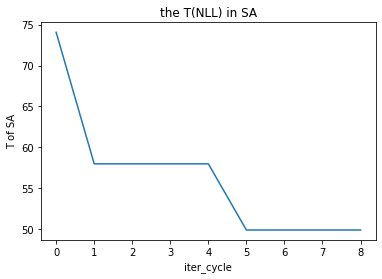

best x:  [-0.29344945  0.45054186  7.72721328]
best y:  49.91387101249883


In [17]:
# draw and print
plt.title("the T(NLL) in SA")
plt.xlabel("iter_cycle")
plt.ylabel("T of SA")
sns.lineplot(x = np.arange(0,sa_boltzmann.iter_cycle+1),y=np.array(sa_boltzmann.generation_best_Y))
plt.show()
print("best x: ",sa_boltzmann.best_x)
print("best y: ",sa_boltzmann.best_y)

In [ ]:
# alpha_g = -0.1
# def g(x):
#     return (1-np.exp(-alpha_g*x))/alpha_g
#
# x_g = pd.DataFrame(np.arange(0,100),index=(np.arange(0,100)),columns=['x'])
# x_g['y'] = x_g.apply(g,axis=1)
# sns.scatterplot(x = x_g['x'],y=x_g['y'])

NameError: name 'c' is not defined